In [1]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scanpy as sc
import sklearn.decomposition #import TruncatedSVD
import scipy 
import sparse, io
import os 
matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

os.chdir('/lunarc/nobackup/projects/regen_immuno/tools/samap/transcriptomes/')
hs_adata=anndata.read_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Cross-tissue_immune_cell_analysis.h5ad')

In [2]:
hs_adata.obs

,donor_id,Predicted_labels_CellTypist,Majority_voting_CellTypist,Majority_voting_CellTypist_high,Manually_curated_celltype,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,...,tissue_ontology_term_id,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
Pan_T7935490_AAACCTGCAAATTGCC,A29,Type 17 helper T cells,Tem/Effector helper T cells,T cells,Trm_Th1/Th17,EFO:0011025,CL:0000492,HsapDv:0000241,PATO:0000461,unknown,...,UBERON:0002116,cell,CD4-positive helper T cell,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage
Pan_T7935490_AAACGGGCATCTGGTA,A29,Cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,UBERON:0002116,cell,"CD8-positive, alpha-beta memory T cell",10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage
Pan_T7935490_AAACGGGTCTTGCATT,A29,Tem/Effector cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,UBERON:0002116,cell,"CD8-positive, alpha-beta memory T cell",10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage
Pan_T7935490_AAAGCAATCATCGCTC,A29,Cytotoxic T cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0011025,CL:0000909,HsapDv:0000241,PATO:0000461,unknown,...,UBERON:0002116,cell,"CD8-positive, alpha-beta memory T cell",10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage
Pan_T7935490_AAAGTAGCAGTCACTA,A29,gamma-delta T cells,gamma-delta T cells,T cells,Trm_Tgd,EFO:0011025,CL:0000798,HsapDv:0000241,PATO:0000461,unknown,...,UBERON:0002116,cell,gamma-delta T cell,10x 5' v1,normal,Homo sapiens,female,ileum,unknown,seventh decade human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CZINY-0112_TTTGGTTAGGCCACTC,D496,MAIT cells,Cytotoxic T cells,T cells,Trm_gut_CD8,EFO:0009922,CL:0000909,HsapDv:0000240,PATO:0000461,unknown,...,UBERON:0000400,cell,"CD8-positive, alpha-beta memory T cell",10x 3' v3,normal,Homo sapiens,male,jejunal epithelium,unknown,sixth decade human stage
CZINY-0112_TTTGGTTCACAAAGTA,D496,Helper T cells,Helper T cells,T cells,Tfh,EFO:0009922,CL:0002038,HsapDv:0000240,PATO:0000461,unknown,...,UBERON:0002106,cell,T follicular helper cell,10x 3' v3,normal,Homo sapiens,male,spleen,unknown,sixth decade human stage
CZINY-0112_TTTGGTTTCCATCACC,D496,Cytotoxic T cells,Cytotoxic T cells,T cells,Tem/emra_CD8,EFO:0009922,CL:0001062,HsapDv:0000240,PATO:0000461,unknown,...,UBERON:0002048,cell,"effector memory CD8-positive, alpha-beta T cel...",10x 3' v3,normal,Homo sapiens,male,lung,unknown,sixth decade human stage
CZINY-0112_TTTGTTGCAGCGGTTC,D496,Helper T cells,Helper T cells,T cells,Tfh,EFO:0009922,CL:0002038,HsapDv:0000240,PATO:0000461,unknown,...,UBERON:0002106,cell,T follicular helper cell,10x 3' v3,normal,Homo sapiens,male,spleen,unknown,sixth decade human stage


In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

# Identify the unique clusters in the 'free_annotation' column
unique_clusters = hs_adata.obs['Manually_curated_celltype'].unique()

# Create a DataFrame to store the selected cell indices
selected_indices = []

# Determine the number of cells to select from each cluster
total_cells_to_keep = int(0.3 * len(hs_adata.obs))
cluster_sizes = hs_adata.obs['Manually_curated_celltype'].value_counts()

# Loop through each cluster and select proportionate cells
for cluster in unique_clusters:
    cluster_indices = hs_adata.obs[hs_adata.obs['Manually_curated_celltype'] == cluster].index
    n_cells_to_keep = int(cluster_sizes[cluster] / len(hs_adata.obs) * total_cells_to_keep)
    selected_indices.extend(np.random.choice(cluster_indices, n_cells_to_keep, replace=False))

# Create a new AnnData object containing only the selected cells
hs_adata_selected = hs_adata[selected_indices].copy()

# Print information about the selected cells
print("Original number of cells:{}".format(hs_adata.n_obs))
print("Number of selected cells:{}".format(hs_adata_selected.n_obs))
#Write the selected cells to a new .h5ad file
hs_adata_selected.write_h5ad('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/Cross-tissue_immune_cell_analysis_selected.h5ad')

/home/nikvaku/Apps/mambaforge-pypy3/envs/compare/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Original number of cells:329762
Number of selected cells:98903


In [4]:
from samap.mapping import SAMAP
from samap.analysis import (get_mapping_scores, GenePairFinder,
                            sankey_plot, chord_plot, CellTypeTriangles,
                            ParalogSubstitutions, FunctionalEnrichment,
                            convert_eggnog_to_homologs, GeneTriangles)
from samalg import SAM
org1 = '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Pw_spleenR1.h5ad'
org2 = '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/Cross-tissue_immune_cell_analysis_selected.h5ad'

filenames = {'pw':org1,'hs':org2}

sm = SAMAP(
        filenames,
        f_maps = 'maps/',
        save_processed=True, #if False, do not save the processed results to `*_pr.h5ad`
        keys = {'pw':'seurat_clusters','hs':'Manually_curated_celltype'},
   )



Processing data pw from:
/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/Anno/Pw_spleenR1.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.9192735554072229
Iteration: 2, Convergence: 0.01989781779202672
Computing the UMAP embedding...
Elapsed time: 73.35889649391174 seconds
Not updating the manifold...
Processing data hs from:
/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/Cross-tissue_immune_cell_analysis_selected.h5ad
RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8941756098800476
Iteration: 2, Convergence: 0.013958851654566432
Computing the UMAP embedding...
Elapsed time: 251.84938836097717 seconds
Not updating the manifold...
24468 `pw` gene symbols match between the datasets and the BLAST graph.
18177 `hs` gene symbols match between the datasets and the BLAST graph.


In [8]:
#Running the SAMAP algorithm
sm.run()
samap = sm.samap

Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Translating feature spaces pairwise.
Projecting data into joint latent space. 113.8600389957428
Correcting data with means. 77.04651045799255
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/6 (0, 117948)
1/6 (20000, 117948)
2/6 (40000, 117948)
3/6 (60000, 117948)
4/6 (80000, 117948)
5/6 (100000, 117948)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 1 complete.
Alignment scores:
          hs       pw
hs  0.000000  0.56888
pw  0.693626  0.00000
Calculating gene-gene correlations in the homology graph...


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Translating feature spaces pairwise.
Projecting data into joint latent space. 79.9664466381073
Correcting data with means. 76.88278269767761
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/6 (0, 117948)
1/6 (20000, 117948)
2/6 (40000, 117948)
3/6 (60000, 117948)
4/6 (80000, 117948)
5/6 (100000, 117948)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 2 complete.
Alignment scores:
          hs        pw
hs  0.000000  0.636271
pw  0.754088  0.000000
Calculating gene-gene correlations in the homology graph...


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Prepping datasets for translation.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Translating feature spaces pairwise.
Projecting data into joint latent space. 71.45931935310364
Correcting data with means. 68.00276398658752
Expanding neighbourhoods of species pw...
Expanding neighbourhoods of species hs...
Indegree coarsening
0/6 (0, 117948)
1/6 (20000, 117948)
2/6 (40000, 117948)
3/6 (60000, 117948)
4/6 (80000, 117948)
5/6 (100000, 117948)
Rescaling edge weights by expression correlations.
Concatenating SAM objects...
Iteration 3 complete.
Alignment scores:
          hs        pw
hs  0.000000  0.640876
pw  0.763465  0.000000
Running UMAP on the stitched manifolds.
Elapsed time: 24.49230098327001 minutes.


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



In [7]:
#Code block to save the results
#from samap.utils import save_samap
#save_samap(sm, '/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/cross_tissue_pw_hs_spl_SAM.pkl')

#To load in SAMAP directly
import pickle
with open('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Inter_data/cross_tissue_pw_hs_spl_SAM.pkl', 'rb') as f:
    sm = pickle.load(f)
samap =sm.samap

AttributeError: 'SAMAP' object has no attribute 'samap'

In [9]:
samap.adata

AnnData object with n_obs × n_vars = 117948 × 102100
    obs: 'pw_orig.ident', 'pw_soup_assign', 'pw_soup_status', 'pw_scds_DropletType', 'pw_combined_status', 'pw_RNA_snn_res.0.8', 'pw_seurat_clusters', 'pw_ident', 'hs_donor_id', 'hs_Predicted_labels_CellTypist', 'hs_Majority_voting_CellTypist', 'hs_Majority_voting_CellTypist_high', 'hs_Manually_curated_celltype', 'hs_assay_ontology_term_id', 'hs_cell_type_ontology_term_id', 'hs_development_stage_ontology_term_id', 'hs_disease_ontology_term_id', 'hs_self_reported_ethnicity_ontology_term_id', 'hs_organism_ontology_term_id', 'hs_sex_ontology_term_id', 'hs_tissue_ontology_term_id', 'hs_suspension_type', 'hs_cell_type', 'hs_assay', 'hs_disease', 'hs_organism', 'hs_sex', 'hs_tissue', 'hs_self_reported_ethnicity', 'hs_development_stage', 'batch', 'species'
    uns: 'neighbors', 'gnnm_corr', 'mapping_K', 'umap', 'homology_gene_names_dict'
    obsm: 'X_umap'
    layers: 'X_disp'
    obsp: 'connectivities'
    varp: 'homology_graph_reweighted'

In [10]:
keys = {'pw':'seurat_clusters','hs':'cell_type'}
D,MappingTable = get_mapping_scores(sm,keys,n_top = 0)
D.head()


hs_classical monocyte                                           pw_15  \
                Cluster Alignment score                         Cluster   
0                 pw_15        0.903461           hs_classical monocyte   
1                 pw_18        0.847118       hs_non-classical monocyte   
2                 pw_12        0.818167  hs_conventional dendritic cell   
3                  pw_9        0.802628              hs_progenitor cell   
4                 pw_19          0.4644                hs_memory B cell   

                                                                pw_6  \
  Alignment score                                            Cluster   
0        0.903461                                   hs_megakaryocyte   
1        0.008333  hs_effector memory CD4-positive, alpha-beta T ...   
2         0.00697  hs_effector memory CD8-positive, alpha-beta T ...   
3        0.005203                                   hs_memory B cell   
4         0.00383  hs_naive thymus-derived CD4-positive, alpha-be...   

                  hs_megakaryocyte                                      pw_18  \
  Alignment score          Cluster Alignment score                    Cluster   
0        0.854084             pw_6        0.854084      hs_classical monocyte   
1        0.040469             pw_8        0.185362     hs_alveolar macrophage   
2        0.028357            pw_10        0.080502  hs_non-classical monocyte   
3        0.016872            pw_14        0.035022             hs_animal cell   
4        0.006697            pw_13        0.006663         hs_progenitor cell   

                   ... hs_group 3 innate lymphoid cell                  \
  Alignment score  ...                         Cluster Alignment score   
0        0.847118  ...                            pw_0        0.139375   
1        0.003582  ...                            pw_3         0.04133   
2        0.002922  ...                            pw_1        0.034161   
3        0.001033  ...                           pw_13        0.015191   
4        0.000321  ...                            pw_4        0.012064   

                                               pw_16                  \
                                             Cluster Alignment score   
0  hs_effector memory CD8-positive, alpha-beta T ...         0.11617   
1  hs_CD8-positive, alpha-beta memory T cell, CD4...        0.061225   
2                      hs_CD4-positive helper T cell         0.04449   
3  hs_effector memory CD4-positive, alpha-beta T ...        0.041035   
4                                      hs_lymphocyte        0.034794   

  hs_plasmacytoid dendritic cell                 hs_dendritic cell, human  \
                         Cluster Alignment score                  Cluster   
0                           pw_0        0.058992                     pw_0   
1                           pw_1        0.027223                     pw_5   
2                           pw_5        0.007302                     pw_2   
3                          pw_14         0.00474                    pw_19   
4                           pw_4        0.003262                     pw_7   

                        hs_pro-B cell                  
  Alignment score             Cluster Alignment score  
0        0.054553                pw_0        0.013333  
1         0.00777                pw_1          0.0046  
2        0.005991                pw_2        0.001286  
3        0.004613  hs_progenitor cell             0.0  
4        0.004075        hs_mast cell             0.0  

[5 rows x 112 columns]

In [12]:
import holoviews
chord_plot(MappingTable, align_thr=0.7)

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/holoviews/core/util.py:1175: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in

:Chord   [source,target]   (value,edge_grp)

<Axes: >

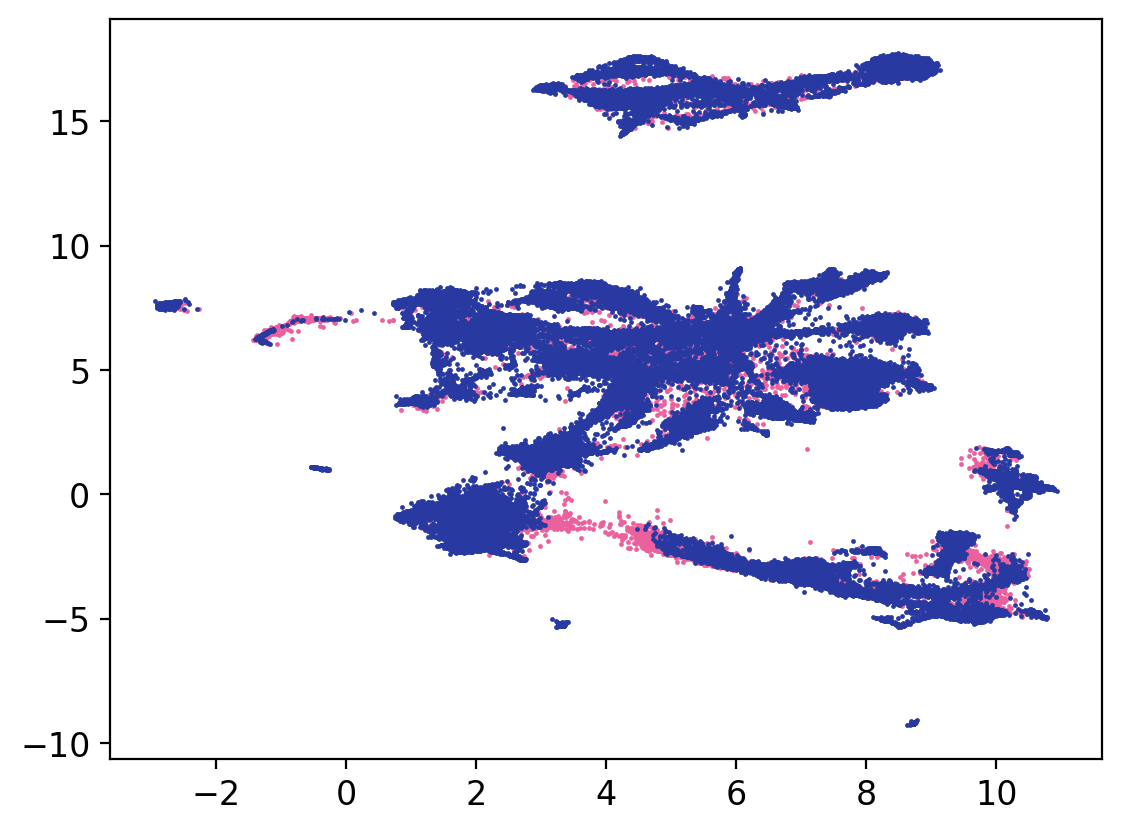

In [11]:
sm.scatter()

<Axes: >

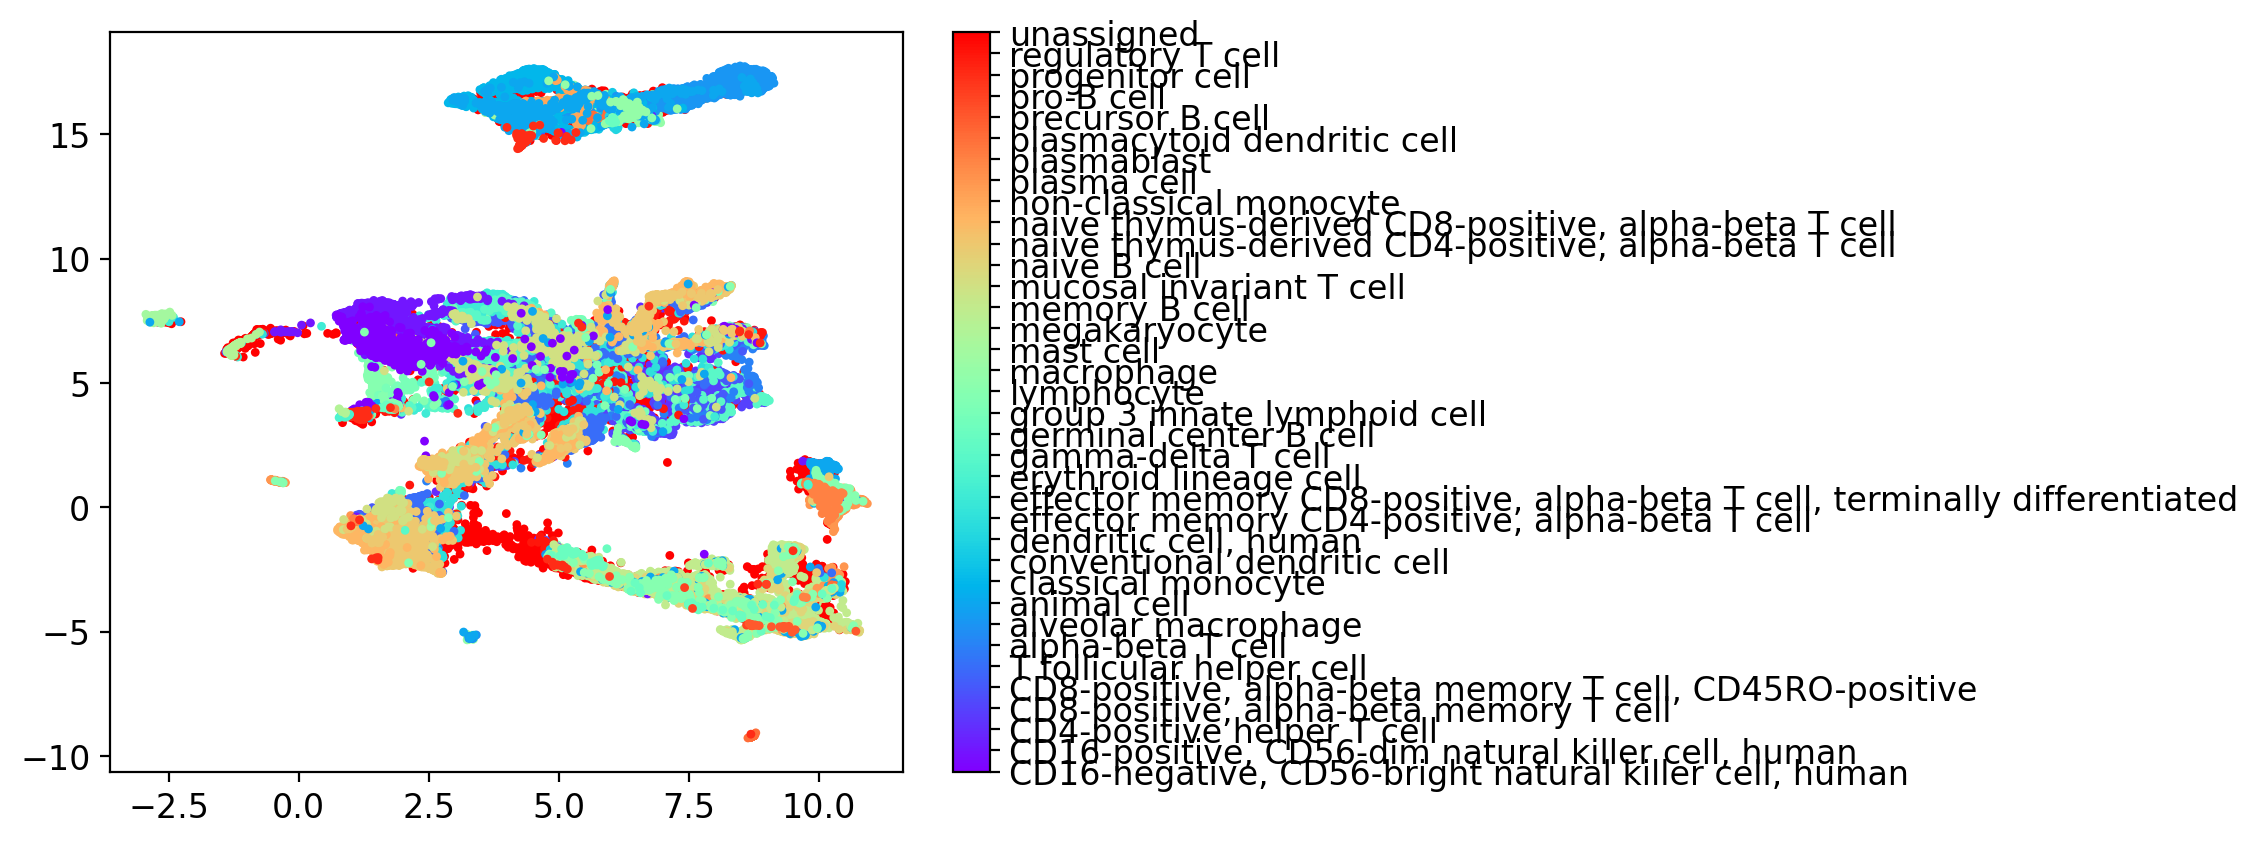

In [12]:
samap.scatter(c='hs_cell_type')

In [13]:
#Finding the mapping Gene pairs

gpf_ct = GenePairFinder(sm,keys=keys);
gene_pairs = gpf_ct.find_all(align_thr=0.3);

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Finding cluster-specific markers in pw:seurat_clusters.
Finding cluster-specific markers in hs:cell_type.
Calculating gene pairs for the mapping: hs;CD4-positive helper T cell to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;CD8-positive, alpha-beta memory T cell to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;CD8-positive, alpha-beta memory T cell, CD45RO-positive to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;T follicular helper cell to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;alpha-beta T cell to pw;3


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;alveolar macrophage to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;12


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;15


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;18


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;19


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;7


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;classical monocyte to pw;9


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;effector memory CD8-positive, alpha-beta T cell, terminally differentiated to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;erythroid lineage cell to pw;13


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;gamma-delta T cell to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;macrophage to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;mast cell to pw;11


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;megakaryocyte to pw;6


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;memory B cell to pw;1


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;memory B cell to pw;2


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;memory B cell to pw;4


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;mucosal invariant T cell to pw;0


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;naive B cell to pw;1


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;non-classical monocyte to pw;5


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Calculating gene pairs for the mapping: hs;plasmablast to pw;14


/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nikvaku/Apps/mambaforge-pypy3/envs/SAMap/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



In [14]:
gene_pairs

,hs_CD4-positive helper T cell;pw_0,hs_CD4-positive helper T cell;pw_0_pval1,hs_CD4-positive helper T cell;pw_0_pval2,"hs_CD8-positive, alpha-beta memory T cell;pw_0","hs_CD8-positive, alpha-beta memory T cell;pw_0_pval1","hs_CD8-positive, alpha-beta memory T cell;pw_0_pval2","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0_pval1","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0_pval2",hs_T follicular helper cell;pw_0,...,hs_mucosal invariant T cell;pw_0_pval2,hs_naive B cell;pw_1,hs_naive B cell;pw_1_pval1,hs_naive B cell;pw_1_pval2,hs_non-classical monocyte;pw_5,hs_non-classical monocyte;pw_5_pval1,hs_non-classical monocyte;pw_5_pval2,hs_plasmablast;pw_14,hs_plasmablast;pw_14_pval1,hs_plasmablast;pw_14_pval2
0,hs_ENSG00000168685;pw_gene16807,0.0,0.0,hs_ENSG00000153563;pw_gene11473,0.0,0.0,hs_ENSG00000153563;pw_gene11473,0.0,0.0,hs_ENSG00000081059;pw_gene53210,...,0.0,hs_ENSG00000104921;pw_gene32806,0.0,0.0,hs_ENSG00000182578;pw_gene53742,0.0,0.0,hs_ENSG00000166803;pw_gene29694,0.0,0.0
1,hs_ENSG00000135046;pw_gene6035,0.0,0.0,hs_ENSG00000213949;pw_gene25459,0.0,0.0,hs_ENSG00000172543;pw_gene37485,0.0,0.0,hs_ENSG00000168685;pw_gene16807,...,0.0,hs_ENSG00000163534;pw_gene55891,0.0,0.0,hs_ENSG00000131042;pw_gene55366,0.0,0.0,hs_ENSG00000132465;pw_gene14113,0.0,0.0
2,hs_ENSG00000111796;pw_gene23053,0.0,0.0,hs_ENSG00000213949;pw_gene24481,0.0,0.0,hs_ENSG00000139187;pw_gene50460,0.0,0.0,hs_ENSG00000169508;pw_gene44286,...,0.0,hs_ENSG00000167483;pw_gene32803,0.0,0.0,hs_ENSG00000131042;pw_gene55363,0.0,0.0,hs_ENSG00000171848;pw_gene39065,0.0,0.000099
3,hs_ENSG00000150991;pw_gene7594,0.0,0.0,hs_ENSG00000213949;pw_gene25572,0.0,0.0,hs_ENSG00000139187;pw_gene50526,0.0,0.0,hs_ENSG00000138795;pw_gene53210,...,0.0,hs_ENSG00000007312;pw_gene44939,0.0,0.0,hs_ENSG00000101336;pw_gene53742,0.0,0.0,hs_ENSG00000211896;pw_gene11429,0.0,0.005157
4,hs_ENSG00000135046;pw_gene15291,0.0,0.000018,hs_ENSG00000204389;pw_gene53400,0.0,0.0,hs_ENSG00000198851;pw_gene26276,0.0,0.0,hs_ENSG00000082074;pw_gene16736,...,0.0,hs_ENSG00000163534;pw_gene8610,0.0,0.0,hs_ENSG00000187116;pw_gene55363,0.0,0.0,hs_ENSG00000211893;pw_gene11429,0.0,0.005157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000129003;pw_gene28296,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000184588;pw_gene10401,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000105287;pw_gene37113,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000243156;pw_gene45919,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Load in the tsv file for mappings
mapper=pd.read_table("/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Raw_data/aPlwal.pri.V2.genome.annots.tsv")
mapper_dict = mapper.set_index('#gene_id')['EggNM.Preferred_name'].to_dict()
mapper_dict

{'gene65541': '.',
 'gene65590': '.',
 'gene65569': 'TSPAN31',
 'gene65568': '.',
 'gene65570': '.',
 'gene43048': '.',
 'gene40732': '.',
 'gene39011': '.',
 'gene40992': '.',
 'gene39884': '.',
 'gene40862': '.',
 'gene40015': 'CCNH',
 'gene42707': 'ESCO2',
 'gene40776': '.',
 'gene38828': '.',
 'gene40270': '.',
 'gene41041': '.',
 'gene42115': '.',
 'gene42541': 'CAPN2',
 'gene43092': '.',
 'gene40366': '.',
 'gene40948': '.',
 'gene38496': '.',
 'gene42460': '.',
 'gene38616': '.',
 'gene42488': '.',
 'gene42331': '.',
 'gene42244': '.',
 'gene40965': '.',
 'gene40239': '.',
 'gene42871': '.',
 'gene41751': 'HEBP2',
 'gene41459': '.',
 'gene40895': '.',
 'gene40724': '.',
 'gene39857': '.',
 'gene41797': '.',
 'gene41937': '.',
 'gene39961': '.',
 'gene43065': 'NLRP3',
 'gene39891': '.',
 'gene43060': '.',
 'gene42127': 'FBXO48',
 'gene42492': '.',
 'gene39574': '.',
 'gene40027': '.',
 'gene39436': '.',
 'gene41201': '.',
 'gene40890': '.',
 'gene42594': '.',
 'gene41094': 'PHF21

In [17]:
for i in gene_pairs.columns:
    if not (i.endswith('pval1') or i.endswith('pval2')):
        for j in gene_pairs[i].index:
            if pd.isna(j):
                continue
            cell_value = gene_pairs.at[j, i]
            if isinstance(cell_value, str):
                hs_pw = cell_value.split(';')
                if len(hs_pw) >= 2:
                    pw = hs_pw[1].split('_')[1]
                #Use the mapper_dict to map
                    if mapper_dict[pw] != '.':
                        hs_pw[1] = mapper_dict[pw]
                        gene_pairs.at[j, i] = ';'.join(hs_pw)

In [20]:
gene_pairs

,hs_CD4-positive helper T cell;pw_0,hs_CD4-positive helper T cell;pw_0_pval1,hs_CD4-positive helper T cell;pw_0_pval2,"hs_CD8-positive, alpha-beta memory T cell;pw_0","hs_CD8-positive, alpha-beta memory T cell;pw_0_pval1","hs_CD8-positive, alpha-beta memory T cell;pw_0_pval2","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0_pval1","hs_CD8-positive, alpha-beta memory T cell, CD45RO-positive;pw_0_pval2",hs_T follicular helper cell;pw_0,...,hs_mucosal invariant T cell;pw_0_pval2,hs_naive B cell;pw_1,hs_naive B cell;pw_1_pval1,hs_naive B cell;pw_1_pval2,hs_non-classical monocyte;pw_5,hs_non-classical monocyte;pw_5_pval1,hs_non-classical monocyte;pw_5_pval2,hs_plasmablast;pw_14,hs_plasmablast;pw_14_pval1,hs_plasmablast;pw_14_pval2
0,hs_ENSG00000168685;IL7R,0.0,0.0,hs_ENSG00000153563;CD8A,0.0,0.0,hs_ENSG00000153563;CD8A,0.0,0.0,hs_ENSG00000081059;TCF7,...,0.0,hs_ENSG00000104921;CLEC17A,0.0,0.0,hs_ENSG00000182578;CSF1R,0.0,0.0,hs_ENSG00000166803;KIAA0101,0.0,0.0
1,hs_ENSG00000135046;ANXA4,0.0,0.0,hs_ENSG00000213949;ITGA4,0.0,0.0,hs_ENSG00000172543;pw_gene37485,0.0,0.0,hs_ENSG00000168685;IL7R,...,0.0,hs_ENSG00000163534;CD22,0.0,0.0,hs_ENSG00000131042;IGSF1,0.0,0.0,hs_ENSG00000132465;IGJ,0.0,0.0
2,hs_ENSG00000111796;pw_gene23053,0.0,0.0,hs_ENSG00000213949;ITGAE,0.0,0.0,hs_ENSG00000139187;pw_gene50460,0.0,0.0,hs_ENSG00000169508;CCR7,...,0.0,hs_ENSG00000167483;pw_gene32803,0.0,0.0,hs_ENSG00000131042;IGSF1,0.0,0.0,hs_ENSG00000171848;RRM2,0.0,0.000099
3,hs_ENSG00000150991;UBC,0.0,0.0,hs_ENSG00000213949;ITGA6,0.0,0.0,hs_ENSG00000139187;CLEC2B,0.0,0.0,hs_ENSG00000138795;TCF7,...,0.0,hs_ENSG00000007312;CD79B,0.0,0.0,hs_ENSG00000101336;CSF1R,0.0,0.0,hs_ENSG00000211896;pw_gene11429,0.0,0.005157
4,hs_ENSG00000135046;ANXA1,0.0,0.000018,hs_ENSG00000204389;pw_gene53400,0.0,0.0,hs_ENSG00000198851;CD3E,0.0,0.0,hs_ENSG00000082074;FYB,...,0.0,hs_ENSG00000163534;FCRL5,0.0,0.0,hs_ENSG00000187116;IGSF1,0.0,0.0,hs_ENSG00000211893;pw_gene11429,0.0,0.005157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000129003;pw_gene28296,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000184588;pw_gene10401,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000105287;pw_gene37113,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,hs_ENSG00000243156;pw_gene45919,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#Save the gene pairs to a csv file
#gene_pairs.to_csv('/home/nikvaku/snic2022-6-312/LabMemberScratchDir/Nikhilesh/Final_Data/cross_tissue_pw_hs_spl_gene_pairs.csv')

In [21]:
#Geneset enrichment analysis for the gene pairs genes in PW

AttributeError: 'SAM' object has no attribute 'values'